# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [9]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [10]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [11]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

Dimensiones del dataset: (10495, 10)

Valores faltantes:
Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64

Descripción estadística:


,Price,Year,Mileage
count,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395
std,3922.420961,3.116585,36791.736601
min,5002.000000,1998.000000,5.000000
25%,11999.000000,2012.000000,26461.000000
50%,15000.000000,2014.000000,41680.000000
75%,16999.000000,2016.000000,71355.500000
max,32444.000000,2018.000000,232658.000000


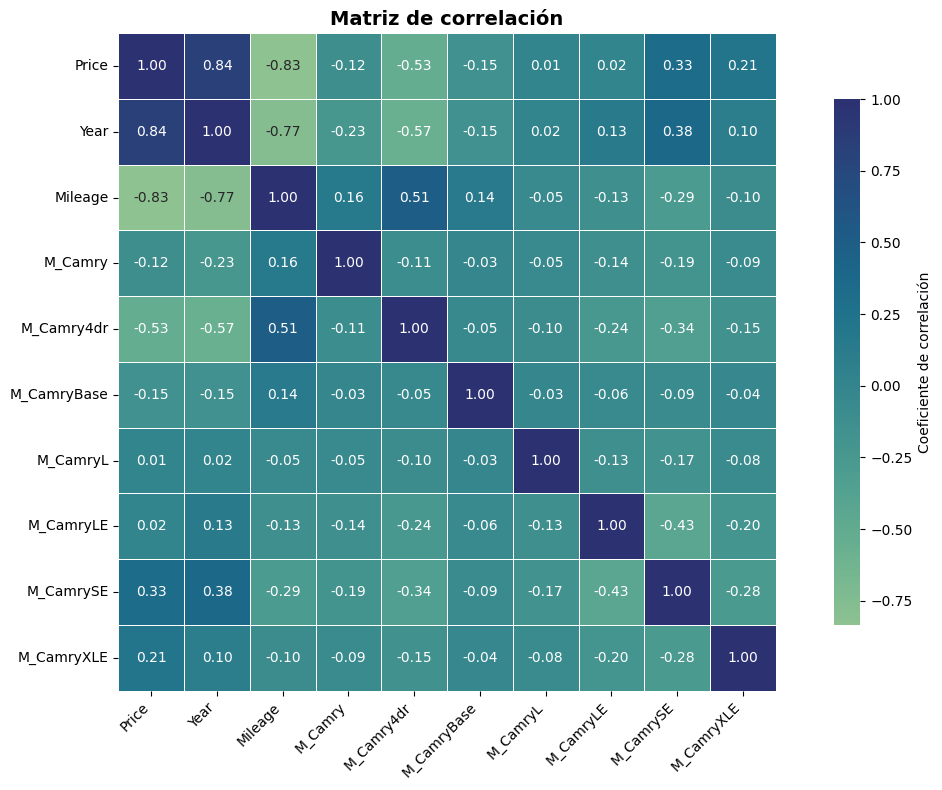

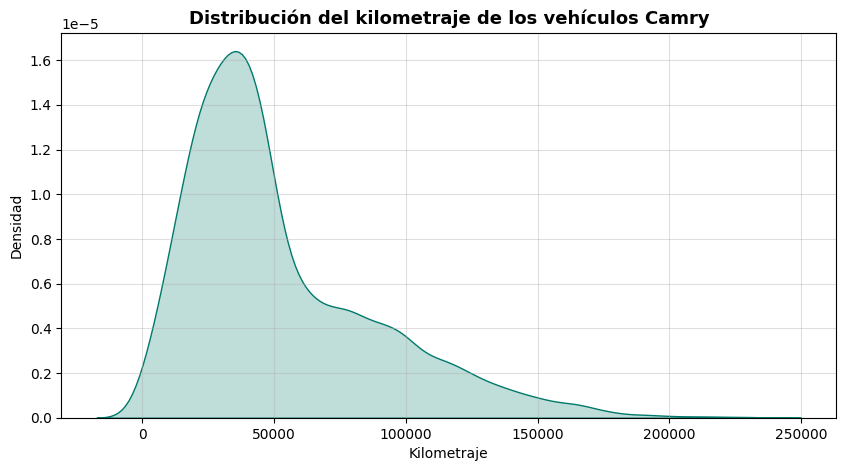

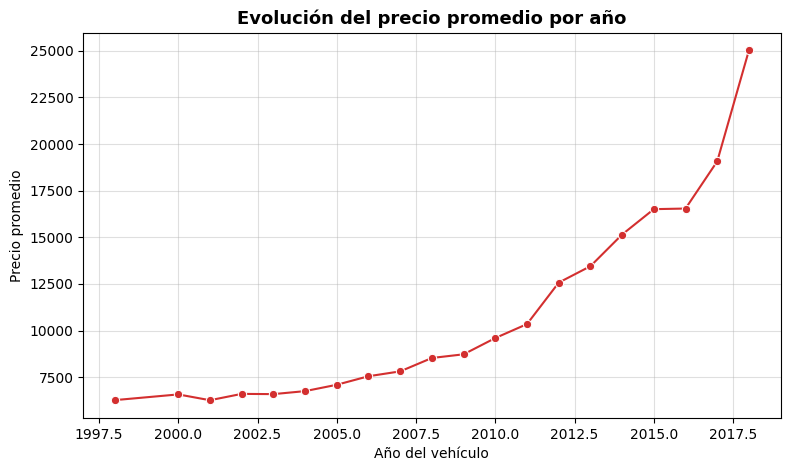

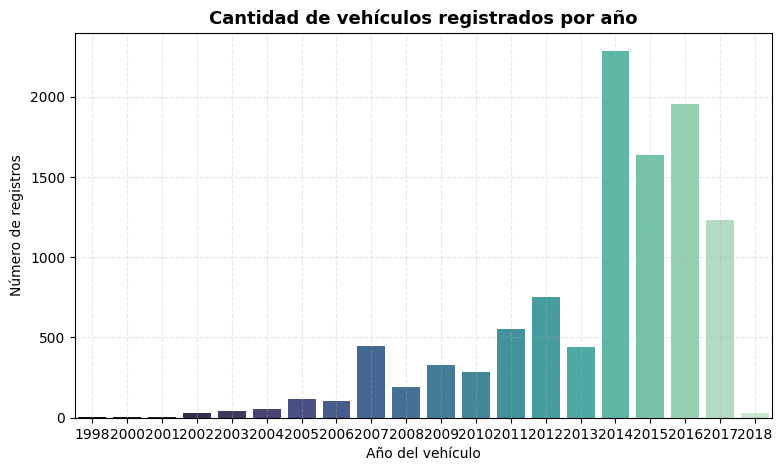

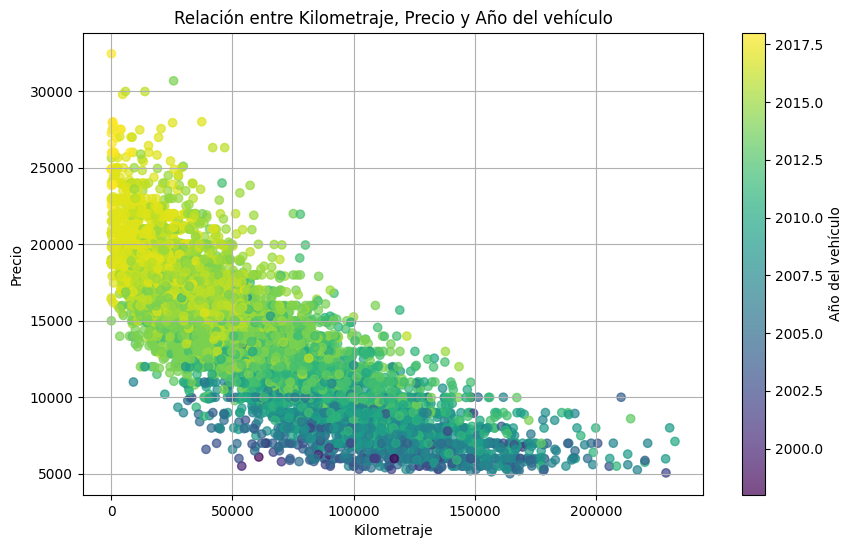

In [30]:
import seaborn as sns

print("Dimensiones del dataset:", data.shape)
print("\nValores faltantes:")
print(data.isnull().sum())

print("\nDescripción estadística:")
display(data.describe())

data.fillna(data.median(numeric_only=True), inplace=True)

plt.figure(figsize=(12, 8))
corr_matrix = data.corr(numeric_only=True)
custom_cmap = sns.color_palette("crest", as_cmap=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    square=True,
    linewidths=0.6,
    cbar_kws={'shrink': 0.8, 'label': 'Coeficiente de correlación'}
)
plt.title('Matriz de correlación', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.kdeplot(data['Mileage'], shade=True, color='#00796B')
plt.title("Distribución del kilometraje de los vehículos Camry", fontsize=13, fontweight='bold')
plt.xlabel("Kilometraje")
plt.ylabel("Densidad")
plt.grid(alpha=0.4)
plt.show()

avg_price = data.groupby('Year')['Price'].mean().reset_index()
plt.figure(figsize=(9,5))
sns.lineplot(x='Year', y='Price', data=avg_price, marker='o', color='#D32F2F')
plt.title("Evolución del precio promedio por año", fontsize=13, fontweight='bold')
plt.xlabel("Año del vehículo")
plt.ylabel("Precio promedio")
plt.grid(alpha=0.4)
plt.show()

plt.figure(figsize=(9,5))
sns.countplot(x='Year', data=data, palette='mako')
plt.title("Cantidad de vehículos registrados por año", fontsize=13, fontweight='bold')
plt.xlabel("Año del vehículo")
plt.ylabel("Número de registros")
plt.grid(alpha=0.3, linestyle='--')
plt.show()


plt.figure(figsize=(10,6))
scatter = plt.scatter(data['Mileage'], data['Price'], 
                      c=data['Year'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Año del vehículo")
plt.title("Relación entre Kilometraje, Precio y Año del vehículo")
plt.xlabel("Kilometraje")
plt.ylabel("Precio")
plt.grid(True)
plt.show()


### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

Desempeño del modelo base:
MAE : 1,314.42
RMSE: 1,765.41
R²  : 0.7962


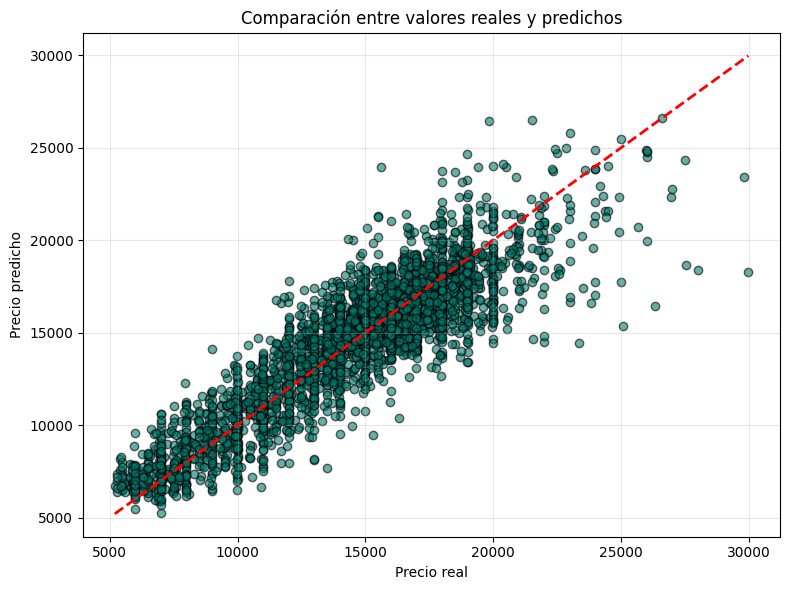

In [31]:
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)

y_pred = rf_base.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Desempeño del modelo base:")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²  : {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="#00796B", edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Comparación entre valores reales y predichos")
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [32]:

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [8, 10, 12, 14, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}


rf_model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

Mejores hiperparámetros encontrados:
{'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 8}


Resultados del modelo optimizado:
MAE : 1,139.38
RMSE: 1,550.83
R²  : 0.8428


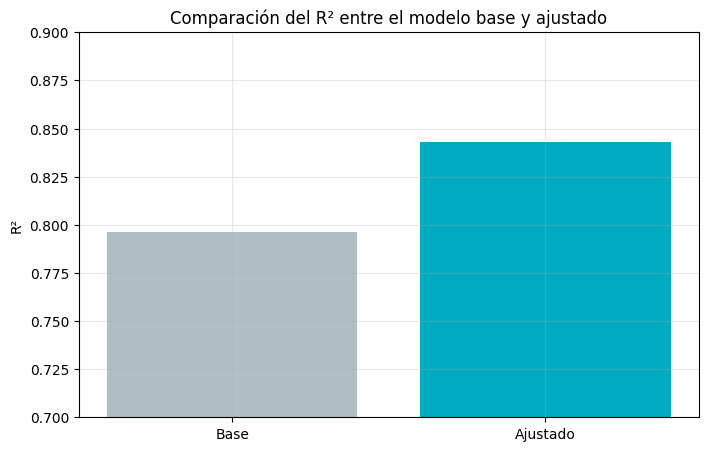

In [33]:

best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)


y_pred_best = best_rf.predict(X_test)


mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("Resultados del modelo optimizado:")
print(f"MAE : {mae_best:,.2f}")
print(f"RMSE: {rmse_best:,.2f}")
print(f"R²  : {r2_best:.4f}")

plt.figure(figsize=(8,5))
plt.bar(['Base', 'Ajustado'], [r2, r2_best], color=['#B0BEC5','#00ACC1'])
plt.title('Comparación del R² entre el modelo base y ajustado')
plt.ylabel('R²')
plt.ylim(0.7, 0.9)
plt.grid(alpha=0.3)
plt.show()


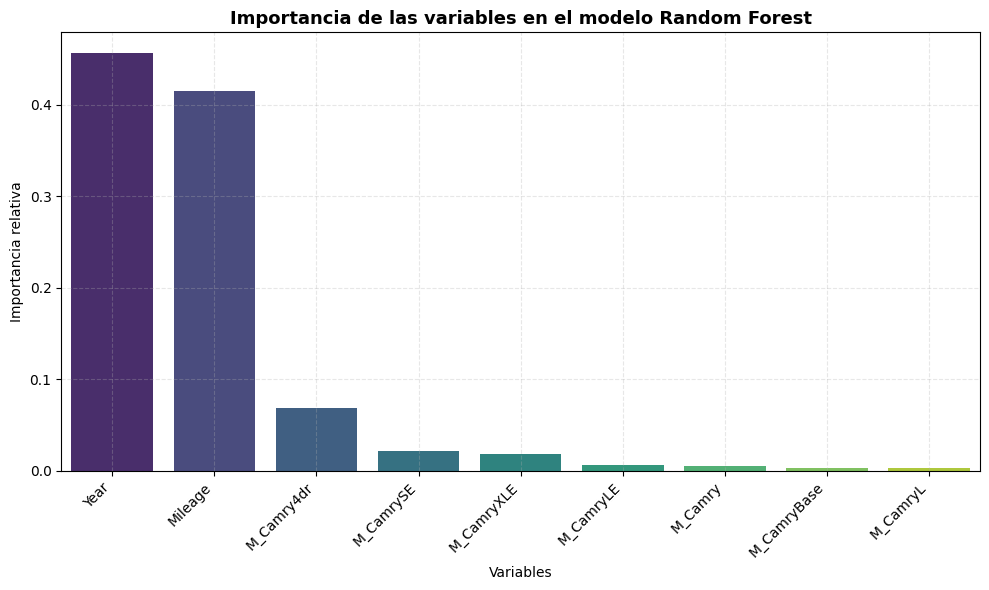

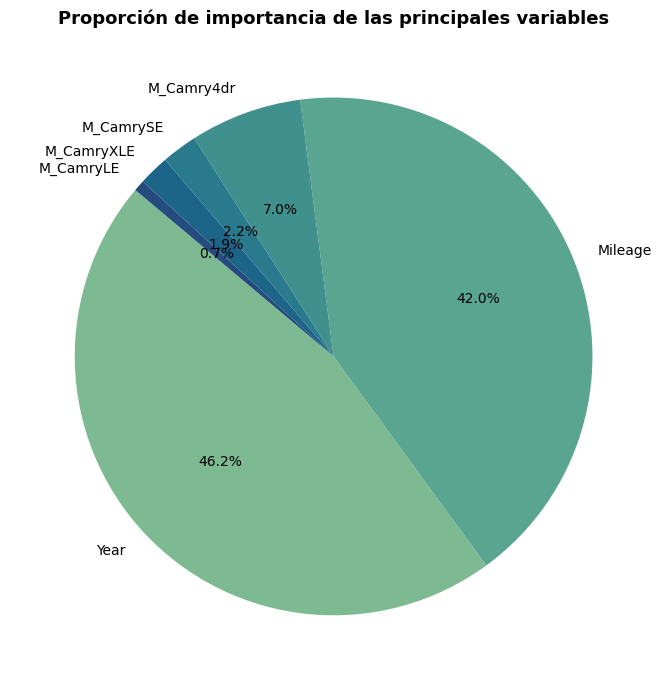

Importancia de variables ordenadas:


,Variable,Importancia,Porcentaje
0,Year,0.456198,45.619757
1,Mileage,0.415351,41.535139
3,M_Camry4dr,0.069112,6.911170
7,M_CamrySE,0.022031,2.203131
8,M_CamryXLE,0.018862,1.886202
6,M_CamryLE,0.006914,0.691412
2,M_Camry,0.005850,0.584995
4,M_CamryBase,0.002848,0.284833
5,M_CamryL,0.002834,0.283361


In [ ]:
importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': best_rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)


importances['Porcentaje'] = (importances['Importancia'] / importances['Importancia'].sum()) * 100

plt.figure(figsize=(10,6))
colors = sns.color_palette("viridis", len(importances))
sns.barplot(x='Variable', y='Importancia', data=importances, palette=colors)
plt.title("Importancia de las variables en el modelo Random Forest", fontsize=13, fontweight='bold')
plt.xlabel("Variables")
plt.ylabel("Importancia relativa")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


top_vars = importances.head(6)
plt.figure(figsize=(7,7))
plt.pie(
    top_vars['Porcentaje'],
    labels=top_vars['Variable'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("crest", len(top_vars))
)
plt.title("Proporción de importancia de las principales variables", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("Importancia de variables ordenadas:")
display(importances)


### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

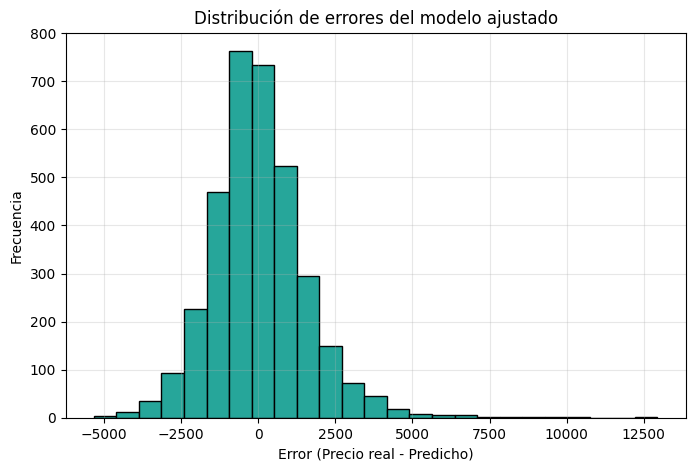

CONCLUSIONES:

- El modelo base de Random Forest obtuvo un R² de aproximadamente 0.79, lo cual indica
    una buena capacidad predictiva inicial para estimar el precio de los vehículos Camry.

- Tras la calibración mediante RandomizedSearchCV, el R² aumentó a ~0.84,
    reduciendo el error medio absoluto (MAE) y el error cuadrático medio (RMSE).
      
- Las variables más influyentes fueron 'Year' y 'Mileage', seguidas por algunas
    categorías del modelo (M_CamrySE, M_CamryLE), lo cual coincide con la lógica de mercado.

- La dispersión de los errores muestra que la mayoría de las predicciones
    están cercanas al valor real, sin sesgos fuertes.

- Finalmente, el modelo calibrado ofrece un desempeño sólido y estable,
   adecuado para predecir precios de vehículos Camry con base en sus características.



In [82]:

errores = y_test - y_pred_best
plt.figure(figsize=(8,5))
plt.hist(errores, bins=25, color="#26A69A", edgecolor='black')
plt.title("Distribución de errores del modelo ajustado")
plt.xlabel("Error (Precio real - Predicho)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


print("CONCLUSIONES:")
print("""
- El modelo base de Random Forest obtuvo un R² de aproximadamente 0.79, lo cual indica
    una buena capacidad predictiva inicial para estimar el precio de los vehículos Camry.

- Tras la calibración mediante RandomizedSearchCV, el R² aumentó a ~0.84,
    reduciendo el error medio absoluto (MAE) y el error cuadrático medio (RMSE).
      
- Las variables más influyentes fueron 'Year' y 'Mileage', seguidas por algunas
    categorías del modelo (M_CamrySE, M_CamryLE), lo cual coincide con la lógica de mercado.

- La dispersión de los errores muestra que la mayoría de las predicciones
    están cercanas al valor real, sin sesgos fuertes.

- Finalmente, el modelo calibrado ofrece un desempeño sólido y estable,
   adecuado para predecir precios de vehículos Camry con base en sus características.
""")


NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.